# Dignity in the ECHR

A belief in human dignity lies at the root of the modern legal commitment to human rights. Appeals to human dignity are to be found in many of the founding documents of this legal regime. The Universal Declaration of Human Rights states in the preamble.

> Whereas the peoples of the United Nations have in the Charter reaffirmed their faith in fundamental human rights, in the dignity and worth of the human person and in the equal rights of men and women and have determined to promote social progress and better standards of life in larger freedom,

The Declaration of Bogotá states that predates the :

>The American peoples have acknowledged the dignity of the individual, and their national constitutions recognize that juridical and political institutions, which regulate life in human society, have as their principal aim the protection of the essential rights of man and the creation of circumstances that will permit him to achieve spiritual and material progress and attain happiness;

The German Basic Law of 1948, in its very first article states categorically:

> Human dignity shall be inviolable. To respect and protect it shall be the duty of all state authority

The African Convention on Human and People's Rights states:

> Considering the Charter of the Organisation of African Unity, which stipulates that “freedom, equality, justice and dignity are essential objectives for the achievement of the legitimate aspirations of the African peoples”;

However dignity is a divisive concept. In the 90s it attracted high-level polemic. Philosopher Anne Ruth Mackor and Psychologist Steven Pinker both rejected the concept as vague, conservative and "stupid". In their view, the concept of dignity .

Similar polemics arose later, now with 

The claims of Mackor and Pinker received replies from believers in dignity, including prominently, human rights lawyers. 

TBC

# **Document** **Clustering (KMeans)**

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re

from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import nltk

In [32]:
# random seed for reproducibility
np.random.seed(123)

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package words to /home/gmas/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /home/gmas/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
class clustering:


    def tf_idf_vectorizer(self, facts_df):
        # Vectorise
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
        # Matrix of vectors that will be used to train KMeans
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        return vectorizer, matrix

    # (Mainly for experiments) Used to understand inertia without first applying dimensionality reduction
    def calculate_inertia(self, facts_df, end, step):
        #tf-idf
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.20, ngram_range=(2,2))
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        # save k-means inertia for each K used to train the model
        inertia_list = []
        for k in range(1,end, step):
          kmeans = KMeans(n_clusters=k, random_state=42)
          kmeans.fit(matrix)
          inertia_list.append(kmeans.inertia_)

        return inertia_list


    # This function is to calculate inertia when SVD is applied, inertia_list used for plotting
    def calc_inertia_svd(self, X_svd, end, step):
      inertia_list = []
      for k in range(1,end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_svd)
        inertia_list.append(kmeans.inertia_)

      return inertia_list

    # This function is to plot the scatter plots of Violation/Non-Violation processed facts
    def view_k_means(self, facts_df, kmeans):

        kmeans.fit(matrix)
        clusters = kmeans.labels_

        # Visualisation
        pca = PCA(n_components=2, random_state=42)
        pca_vecs = pca.fit_transform(matrix.toarray())
        x0 = pca_vecs[:, 0]
        x1 = pca_vecs[:, 1]
        facts_df['Cluster'] = clusters
        facts_df['x0'] = x0
        facts_df['x1'] = x1

        # getting the top keywords
        top_words = pd.DataFrame(matrix.todense()).groupby(clusters).mean()
        terms = vectorizer.get_feature_names_out()
        for i,r in top_words.iterrows():
            print('\nCluster {}'.format(i))
            print(','.join([terms[t] for t in np.argsort(r)[-20:]]))


        cluster_map = {0: 'Private Life',
                        1: 'Injury',
                        2: 'Prisoner',
                        3: 'Confinement',
                        4:'Defamation'}


        facts_df['Cluster'] = facts_df['Cluster'].map(cluster_map)


# please check the title here, is it correct? 
        
        # set image size
        plt.figure(figsize=(12, 7))
        # set a title
        plt.title("Processed Non-Violation Facts - Document clustering", fontdict={"fontsize": 18})
        # set axes names
        plt.xlabel("X0", fontdict={"fontsize": 16})
        plt.ylabel("X1", fontdict={"fontsize": 16})
        # create scatter plot with seaborn, where hue is the class used to group the data
        sns.scatterplot(data=facts_df, x='x0', y='x1', hue='Cluster', palette="Paired", s = 50)
        plt.show()


## Importing all files

In [24]:
all_processed_facts = pd.read_csv('facts_processed.csv')
all_processed_facts.head(10)

,Facts
0,born life vilnius around motorcycle collided c...
1,introduction lived worked farmer village kuşko...
2,detail concerning found annex background oliar...
3,born life râmnicu vâlcea pretrial detention ag...
4,born life louvencourt hired french national ra...
5,born currently detained iaşi prison detained p...
6,born life shropshire severely disabled result ...
7,born life warsaw submitted party summarised ar...
8,information relevant set appended table compla...
9,born life dubrovnik incident around dubrovnik ...


Some more pre-processing (Removing non-english words and words that have less than three letters)

In [13]:
def remove_lang_words(facts_words, english_words):
  # Filtering out non-english words and three letter words
  filtered = [word for word in facts_words if word in english_words and len(word)>3]
  return filtered

In [25]:
new_facts = pd.DataFrame(columns=['Facts'])
english_words = set(nltk.corpus.words.words())

for fact in all_processed_facts['Facts']:
  fact_words = fact.split()
  facts_words_filtered = remove_lang_words(fact_words, english_words)
  new_fact = ' '.join(facts_words_filtered)
  new_row = pd.DataFrame({'Facts': [new_fact]})
  new_facts = pd.concat([new_facts, new_row], ignore_index=True)

new_facts.head(10)

,Facts
0,born life around motorcycle driven residential...
1,introduction lived worked farmer village close...
2,detail concerning found annex background stabl...
3,born life detention aged detention hour follow...
4,born life hired national railway company last ...
5,born currently prison pending charge departmen...
6,born life severely disabled result syndrome pr...
7,born life warsaw party arrest doctor emergency...
8,information relevant table confinement metal c...
9,born life incident around station hereinafter ...


In [26]:
len(new_facts)

1113

## > Perhaps the class name should change to be more like a noun than a verb

In [11]:
clusters = clustering()

PCA applied by means of the Singular Value Decomposition (SVD)

In [33]:
vectorizer, matrix = clusters.tf_idf_vectorizer(new_facts)

In [34]:
svd = TruncatedSVD(n_components = 500, random_state = 42)
X_svd = svd.fit_transform(matrix)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.75


In [35]:
X_svd.shape

(1113, 500)

### Inertia

The measure of inertia can be used in order to help determine the number of clusters to be used. Here we explore the inertia scores for 1 to 20 clusters. Inertia is defined as the sum of squared distances obtained by a distance function *dist* from each data point *i* to its hypothesized centroid *c*, for each hypothesized cluster *k*. 

$$  \sum_{k=1}^{k=n} \sum_{i=1}^{i=n} (dist(c,i))^2  $$

While a lower inertia score is preferred, inertia will naturally increase with the number of clusters, and will be minimized when every data point i is assigned to its own cluster. So in practice what is needed is a compromise between the inertia score and the number of clusters. This is commonly found visually using the elbow method. This looks for the places where the slope of the curve of inertia over the number of clusters deaccelerates. Here we find an elbow at around 5 clusters, and another around 11. However qualitatively we seem to get the best interpretable results at 8 clusters.

Text(0.5, 1.0, 'Calculating Inertia for K Clusters')

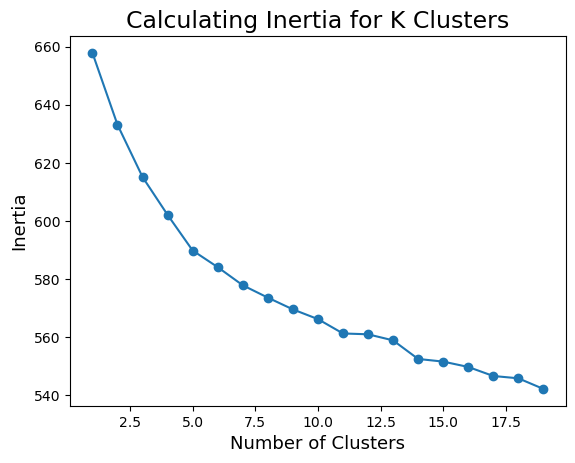

In [37]:
inertia_list = clusters.calc_inertia_svd(X_svd, 20, 1)
plt.plot(range(1,20, 1),inertia_list)
plt.scatter(range(1,20, 1),inertia_list)
#plt.scatter(8, inertia_list[8], marker="X", s=300, c="r")

plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia", size=13)
plt.title("Calculating Inertia for K Clusters", size=17)

### K Clusters - Svd - Silhouette Experiment
To backup the results obtained from the Inertia-Curve by calculating the silhouette score for each K.

> I need to read up on this measures. We need a small description of them for the notebook. I can do it, as I need to read up on them anyways.  
> since 50 clusters is not humanly understandable (in this type of research) I don't know if the experiment should run so far.

In [38]:
best_combination = pd.DataFrame(columns= ['K', 'SVD', 'Var', 'Silhouette'])
k_list = []
components_list = []
variance_list = []
silhouette_list = []
max_sil = -2
for k in range(4, 50):
  #for components in range(1, len(new_facts), 5):
  svd = TruncatedSVD(n_components = 140, random_state = 42)
  X_svd = svd.fit_transform(matrix)

  k_means = KMeans(n_clusters=k, random_state=42)
  in_y_pred = k_means.fit_predict(X_svd)
  silhouette_avg = silhouette_score(X_svd, in_y_pred)

  if max_sil < silhouette_avg:
    max_sil = silhouette_avg

  k_list.append(k)
  components_list.append(140)
  variance_list.append(np.sum(svd.explained_variance_ratio_))
  silhouette_list.append(silhouette_avg)


best_combination['K'] = k_list
best_combination['SVD'] = components_list
best_combination['Var'] = variance_list
best_combination['Silhouette'] = silhouette_list

print(max_sil)
best_combination.head()

0.10559440286973562


,K,SVD,Var,Silhouette
0,4,140,0.416115,0.075284
1,5,140,0.416115,0.079293
2,6,140,0.416115,0.079433
3,7,140,0.416115,0.078692
4,8,140,0.416115,0.082217


In [ ]:
best_combination

,K,SVD,Var,Silhouette
0,4,140,0.706181,0.006374
1,5,140,0.706181,0.027540
2,6,140,0.706181,0.014314
3,7,140,0.706181,0.024445
4,8,140,0.706181,0.030629
5,9,140,0.706181,0.025444
6,10,140,0.706181,0.040244
7,11,140,0.706181,0.032462
8,12,140,0.706181,0.037515
9,13,140,0.706181,0.032102


## Word Clouds
Showing the top 100 (tf-idf) words for each cluster. Visualisation method used is Word Clouds, plotting code provided by: https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial


In [29]:
def word_cloud_generator(X, in_X_tfidf, k, in_word_positions):
  # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_cluster_ids, in_model

> 8 clusters show even better results
> some of these words can be stop words, and things will be better when we remove them Examples "whether", 

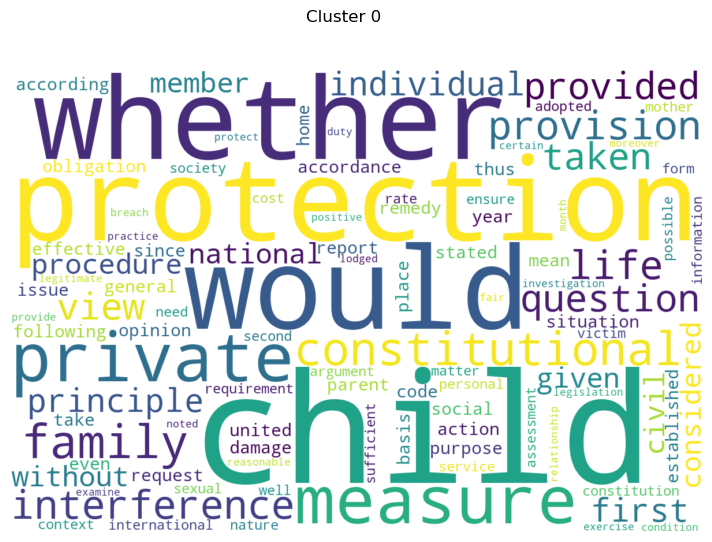

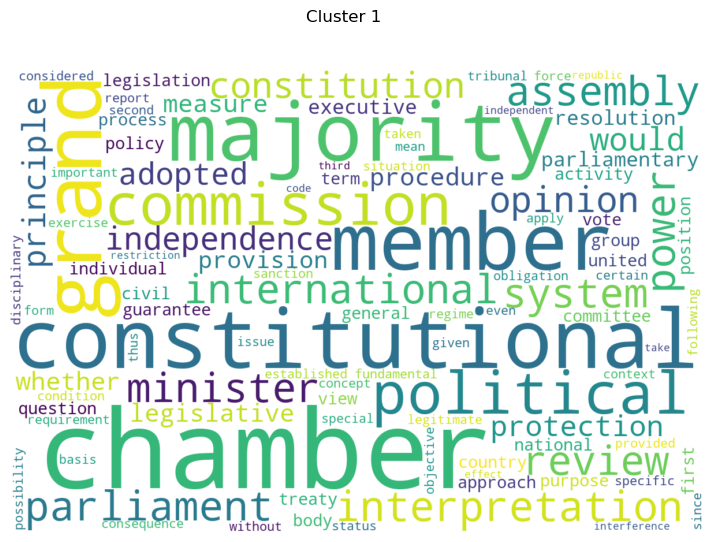

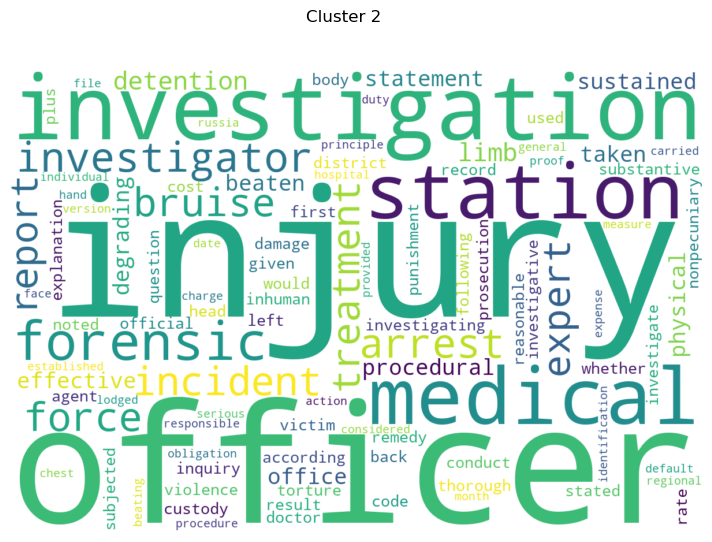

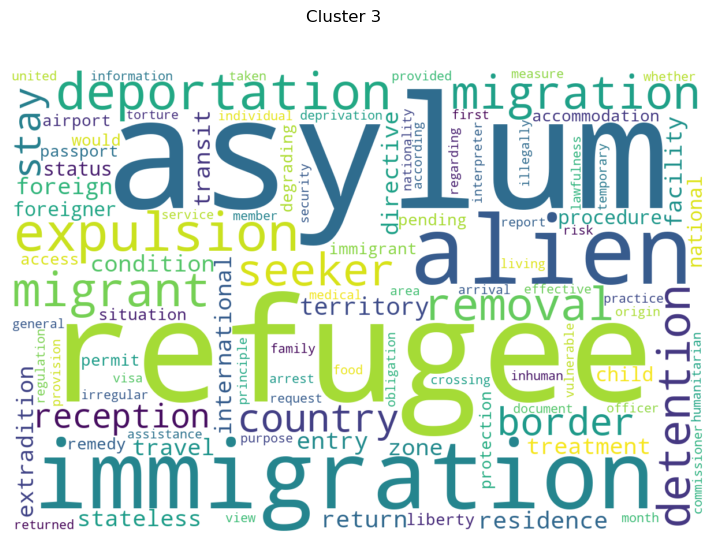

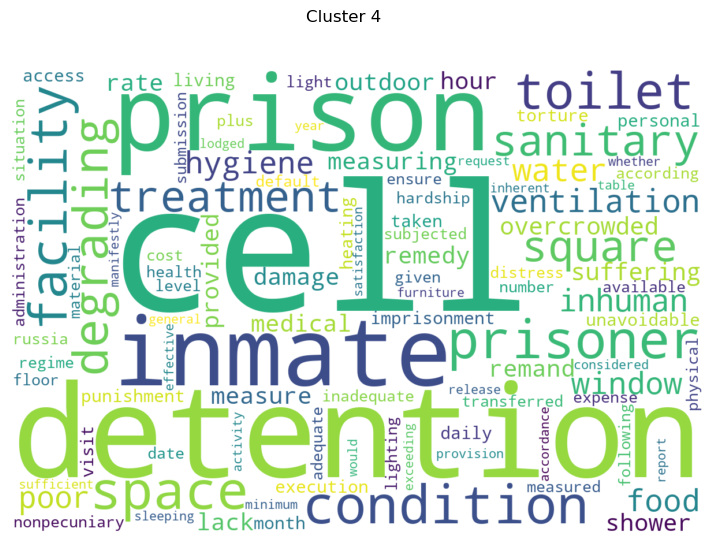

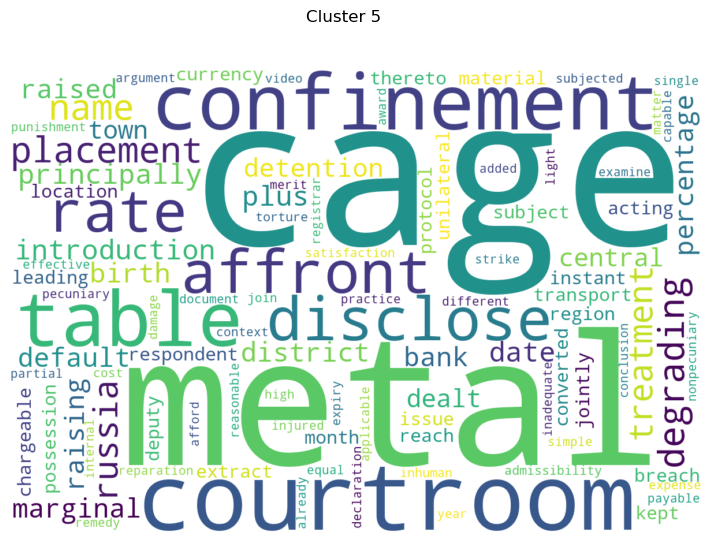

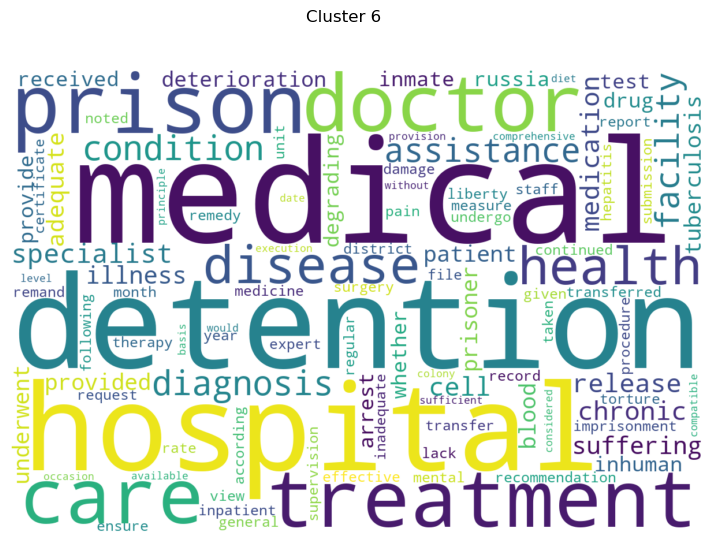

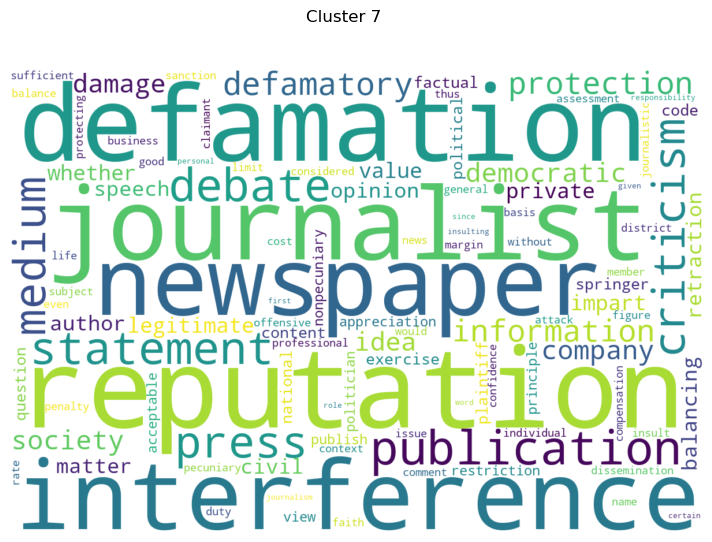

In [33]:
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids, kmeans = word_cloud_generator(X_svd, matrix, 8, word_positions)

### Another visualisation method: Scatter plot


Cluster 0
international,first,provided,national,interference,view,question,individual,life,principle,private,family,provision,constitutional,whether,member,measure,would,child,protection

Cluster 1
bruise,physical,effective,procedural,statement,expert,taken,report,force,incident,detention,investigator,treatment,arrest,forensic,station,medical,investigation,injury,officer

Cluster 2
care,remedy,health,doctor,hospital,provided,toilet,suffering,inhuman,space,degrading,prisoner,medical,facility,treatment,inmate,condition,prison,cell,detention

Cluster 3
default,raised,birth,date,plus,introduction,principally,treatment,russia,placement,name,degrading,rate,affront,disclose,confinement,table,courtroom,metal,cage

Cluster 4
legitimate,whether,company,damage,society,democratic,information,protection,defamatory,medium,criticism,press,debate,statement,publication,newspaper,interference,journalist,defamation,reputation


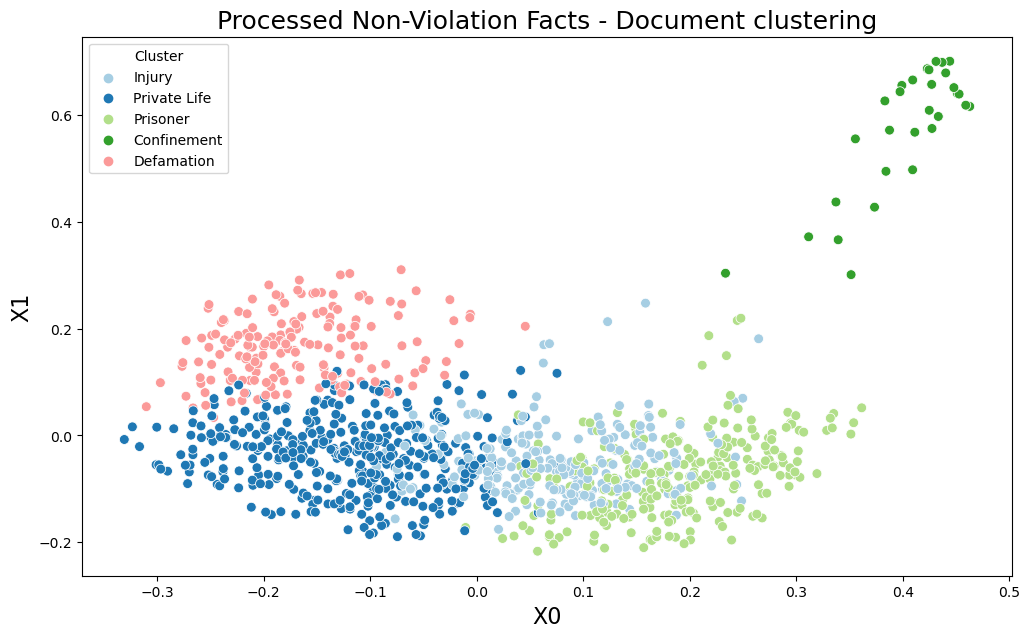

In [31]:
clusters.view_k_means(all_processed_facts, kmeans)

> The plot is very interesting. I think we should have one for all cases, one for violation and one for non violation cases. I think the title is wrong and this one is for all cases.


> Could we get the typical cases by cluster? I think you settled on kmeans, that would be the case or cases closest to each centroid right?